# Testing Out The PMF Estimator!
## Test 1
Can we predict just the distribution using a given wave int and depth? This should be a simple enough task but with very 
tiny number of data

In [1]:
from inverse_modelling_tfo.model_training.custom_models import PMFEstimatorNet
from pathlib import Path
import json
import pandas as pd
from model_trainer import HoldOneOut, RandomSplit, DataLoaderGenerator, ModelTrainer, TorchLossWrapper
from torch.optim import SGD
from model_trainer import ModelTrainer, RandomSplit, TorchLossWrapper, DataLoaderGenerator
import torch.nn as nn
import matplotlib.pyplot as plt 


# Load the exp terms data
l4_dist_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "l4_bins.pkl"
l4_dist_data = pd.read_pickle(l4_dist_data_path)
l4_dist_config_path = l4_dist_data_path.with_suffix('.json')
with open(l4_dist_config_path, 'r') as file:
    l4_dist_config = json.load(file)
chosen_detector_index = l4_dist_config['chosen_detector_index']

# Get the Feature Column names
l4_dist_columns = l4_dist_config['features']
l4_dist_columns = [str(x) for x in l4_dist_columns]

# The values do not add up to one because of thresholding - create a new excess column to account for this
l4_dist_data['excess'] = 1 - l4_dist_data[l4_dist_columns].sum(axis=1)
l4_dist_columns = l4_dist_columns + ['excess']

# Show
l4_dist_data.head()

,0.0,1.45708,2.7891,5.33881,10.21937,19.56159,37.44415,71.67437,137.19674,262.61751,Wave Int,Maternal Wall Thickness,excess
0,0.707548,0.005890,0.009654,0.014133,0.019081,0.024692,0.030225,0.035007,0.037641,0.037014,2,14,0.079115
1,0.414523,0.012100,0.020084,0.029892,0.041073,0.054029,0.066543,0.076601,0.079856,0.074127,2,8,0.131171
2,0.312103,0.013937,0.022342,0.032796,0.045969,0.061152,0.076766,0.089899,0.095177,0.088883,1,6,0.160975
3,0.767299,0.004674,0.007378,0.010559,0.014160,0.018154,0.022445,0.026212,0.028770,0.029018,1,16,0.071330
4,0.351096,0.013348,0.022004,0.032939,0.045684,0.060485,0.075219,0.086315,0.089818,0.082412,2,7,0.140680


## Creating The Network
We are going to create a network that predicts these distributions(named l4_dist_columns) using Wave Int and Maternal Wall Thickness

In [2]:
x_columns = ['Wave Int', 'Maternal Wall Thickness']
y_columns = l4_dist_columns
print("X Columns: ", x_columns)
print("Y Columns: ", y_columns)
print("Input Length: ", len(x_columns))
print("Output Length: ", len(y_columns))
print("Total Data Length: ", len(l4_dist_data))

model = PMFEstimatorNet([len(x_columns), 5, len(y_columns)], [0.5, 0.5])
criterion = TorchLossWrapper(nn.MSELoss(), name='MSE')
validation_method = RandomSplit(0.7)
datagen = DataLoaderGenerator(l4_dist_data, x_columns, y_columns, batch_size=4)

trainer = ModelTrainer(model, datagen, validation_method, criterion)

X Columns:  ['Wave Int', 'Maternal Wall Thickness']
Y Columns:  ['0.0', '1.45708', '2.7891', '5.33881', '10.21937', '19.56159', '37.44415', '71.67437', '137.19674', '262.61751', 'excess']
Input Length:  2
Output Length:  11
Total Data Length:  62


In [3]:
trainer.set_optimizer(SGD, {'lr': 4e-4, 'momentum': 0.91, 'nesterov': True})
trainer.run(100)

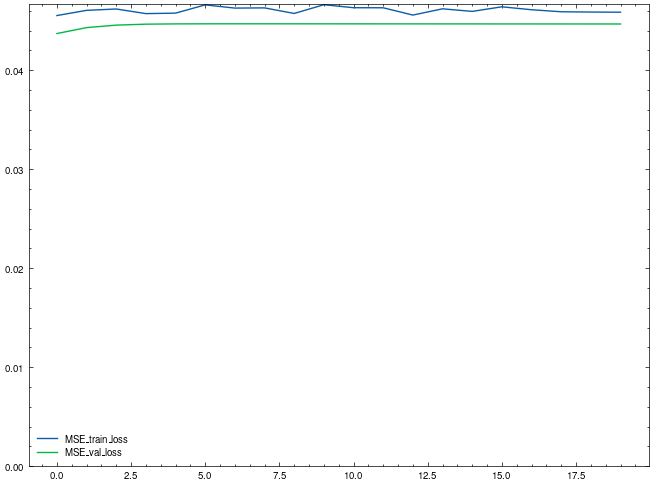

In [7]:
criterion.loss_tracker.plot_losses()
plt.show()

## Test 2
Can we make the same PMF predictions when we are given the intensity values(At a single wavelength) rather than the depth.
The intensity should, in theory, contain the depth information. But slightly more convoluted. 

## Combining Intensity Values with Distribution Columns

In [4]:
from inverse_modelling_tfo.data_merger_routines import merge_l4_dist
# Load the log intensity data
i1_and_i2_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2_interp.pkl"
i1_and_i2 = pd.read_pickle(i1_and_i2_data_path)
i1_and_i2_config_path = i1_and_i2_data_path.with_suffix('.json')
with open(i1_and_i2_config_path, 'r') as file:
    i1_and_i2_config = json.load(file)
intensity_columns = i1_and_i2_config['features']

data = merge_l4_dist(l4_dist_data_path, i1_and_i2)

## Filtering Out Only 1 Wavelength

In [5]:
wave_int = '2'  # or '1'

# Drop irrelevant path distribution columns from data
wave_int_to_drop = '1' if wave_int == '2' else '2'
columns_to_drop = [col for col in data.columns if col.endswith(f'WV{wave_int_to_drop}')]
data = data.drop(columns=columns_to_drop) 
l4_dist_columns_selected_wv = [col for col in data.columns if col.endswith(f'WV{wave_int}')]
data["excess WV1"] = data[l4_dist_columns_selected_wv].sum(axis=1)


# Keep only the columns that are relevant to the wave_int
x_columns = [col for col in intensity_columns if f'_{wave_int}.0_' in col]
y_columns = l4_dist_columns_selected_wv + ['excess WV1']
print("X Columns: ", x_columns)
print("Y Columns: ", y_columns)
print("Input Length: ", len(x_columns))
print("Output Length: ", len(y_columns))
print("Total Data Length: ", len(data))

X Columns:  ['10_2.0_1', '15_2.0_1', '19_2.0_1', '24_2.0_1', '28_2.0_1', '33_2.0_1', '37_2.0_1', '41_2.0_1', '46_2.0_1', '50_2.0_1', '55_2.0_1', '59_2.0_1', '64_2.0_1', '68_2.0_1', '72_2.0_1', '77_2.0_1', '81_2.0_1', '86_2.0_1', '90_2.0_1', '94_2.0_1', '10_2.0_2', '15_2.0_2', '19_2.0_2', '24_2.0_2', '28_2.0_2', '33_2.0_2', '37_2.0_2', '41_2.0_2', '46_2.0_2', '50_2.0_2', '55_2.0_2', '59_2.0_2', '64_2.0_2', '68_2.0_2', '72_2.0_2', '77_2.0_2', '81_2.0_2', '86_2.0_2', '90_2.0_2', '94_2.0_2']
Y Columns:  ['0.0 WV2', '1.45708 WV2', '2.7891 WV2', '5.33881 WV2', '10.21937 WV2', '19.56159 WV2', '37.44415 WV2', '71.67437 WV2', '137.19674 WV2', '262.61751 WV2', 'excess WV1']
Input Length:  40
Output Length:  11
Total Data Length:  515592


## Creating The Network

In [38]:
datagen = DataLoaderGenerator(data, x_columns, y_columns, batch_size=1024)
criterion = TorchLossWrapper(nn.MSELoss(), name='MSE')
validation_method = RandomSplit(0.7)
model = PMFEstimatorNet([len(x_columns), 20, len(y_columns)], [0.5, 0.5])

trainer = ModelTrainer(model, datagen, validation_method, criterion)

In [39]:
trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.94, 'nesterov': True})
trainer.run(100)

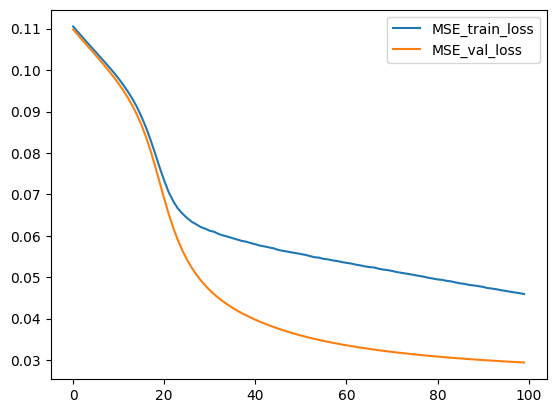

In [40]:
criterion.loss_tracker.plot_losses()

__Comments__:
1. We actually can get very similar loss to the depth case. Even better here actually. (But that's probably due to tuning)
2. This was done without normalization. I wonder if that plays some sort of role

  
## Test 3
Can we extend these results for the held one out case?

In [44]:
from model_trainer import HoldOneOut

datagen = DataLoaderGenerator(data, x_columns, y_columns, batch_size=1024)
criterion = TorchLossWrapper(nn.MSELoss(), name='MSE')
all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut('Maternal Wall Thickness', all_depths[len(all_depths) // 2]) # Center of the list
model = PMFEstimatorNet([len(x_columns), 20, len(y_columns)], [0.5, 0.5])

trainer = ModelTrainer(model, datagen, validation_method, criterion)

In [45]:
trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.94, 'nesterov': True})
trainer.run(100)

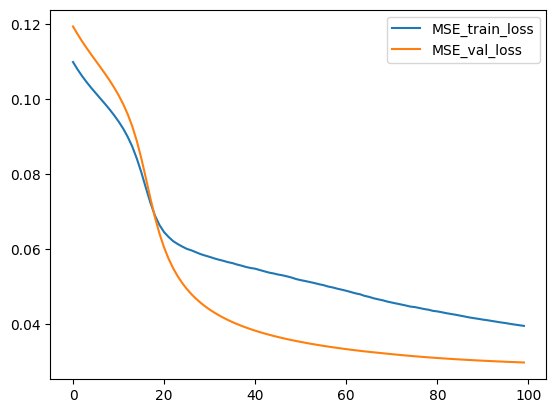

In [46]:
criterion.loss_tracker.plot_losses()

__Comments__:
1. Even in this held one out case, it still shows very similar performance

# Test 4
Scaled Data + Hold One Out  
__Note__: We only want to scale the input intensities. NOT the PMF. Scaling PMFs will break their inherent PMF qualities! BEWARE!

## Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
data_scaled = data.copy()

x_scaler = StandardScaler()
data_scaled[x_columns] = x_scaler.fit_transform(data_scaled[x_columns])

## Creating The Network

In [14]:
datagen = DataLoaderGenerator(data_scaled, x_columns, y_columns, batch_size=1024)
criterion = TorchLossWrapper(nn.MSELoss(), name='MSE')
all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut('Maternal Wall Thickness', all_depths[len(all_depths) // 2]) # Center of the list
model = PMFEstimatorNet([len(x_columns), 20, 15, len(y_columns)])

trainer = ModelTrainer(model, datagen, validation_method, criterion)

In [15]:
from torch.optim import SGD

trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.94, 'nesterov': True})
trainer.run(50)

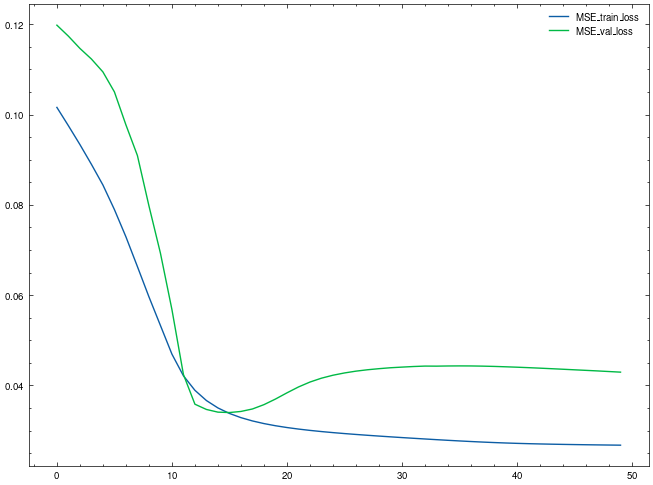

In [18]:
_ = criterion.loss_tracker.plot_losses()

__Comments__:
1. Scaling seems to make the losses start out in a more stable fashion. Which is definitely a good thing! 
2. IMO using LOG should not really make much of a difference here with MLPs. Yes they would make the values accross different detectors 
move to closer range, but the scaling already does that. Rather if we wanted to preserve shape or something, then the log would be 
beneficial. i.e., using a CNN rather than an MLP)

# Test 5
Visualize Each Loss Independently



In [7]:
from model_trainer import SumLoss

datagen = DataLoaderGenerator(data_scaled, x_columns, y_columns, batch_size=1024)
criterion_list = []
for index, col in enumerate(y_columns):
    criterion_list.append(TorchLossWrapper(nn.MSELoss(), [index], name=f'MSE_{col}'))

criterion = SumLoss(criterion_list, [1.0] * len(criterion_list), name='SumMSE')
all_depths = data_scaled["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut('Maternal Wall Thickness', all_depths[len(all_depths) // 2]) # Center of the list
model = PMFEstimatorNet([len(x_columns), 20, len(y_columns)], [0.5, 0.5])

trainer = ModelTrainer(model, datagen, validation_method, criterion)

In [8]:
trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.94, 'nesterov': True})
trainer.run(100)

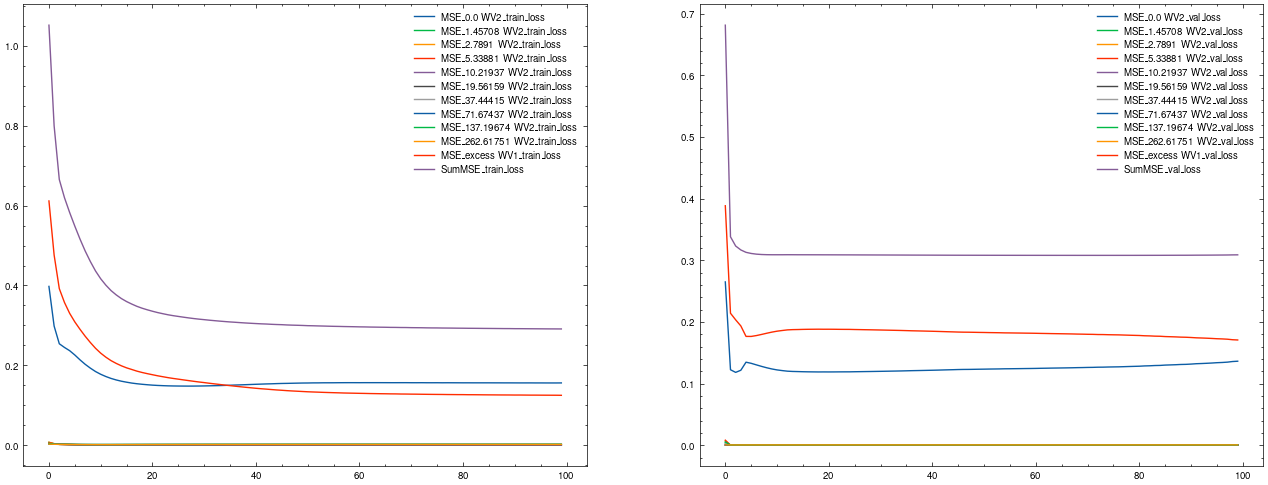

In [10]:
import matplotlib.pyplot as plt

_ = criterion.loss_tracker.plot_losses('split')
# Make the legend out side the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

__Comments__: 
1. The SumLoss here is not averaged. Which is why it looks larger than the total losses from previous plots. 
2. The largest loss values come from the PMF at 0 and the excess. The excess, we can overlook since it doesn't really mean much. The Zero bin however
is much more concerning!